# Backpack Prediction Challenge
#### Playground Series - Season 5, Episode 2

https://www.kaggle.com/competitions/playground-series-s5e2/

In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
# ^^^ pyforest auto-imports - don't write above this line
import pandas as pd
import numpy as np
from termcolor import colored


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.impute import SimpleImputer
from scipy.stats import shapiro, kendalltau, kruskal, mannwhitneyu


import os
import warnings
warnings.filterwarnings("ignore")

In [6]:
path = 'D:\\etude_data_science\\Kaggle_competition\\13_Backpack_Prediction_Challenge\\dataset\\'

In [7]:
os.listdir(path)

['playground-series-s5e2.zip',
 'sample_submission.csv',
 'test.csv',
 'train.csv',
 'training_extra.csv']

In [8]:
train = pd.read_csv(path+"training_extra.csv")
train2 = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")


In [9]:
print(train.shape)
train.head()

(3694318, 11)


,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,500000,Under Armour,Canvas,Small,10.0,Yes,Yes,Tote,Blue,23.882052,114.11068
1,500001,Puma,Polyester,Small,4.0,No,Yes,Backpack,Green,11.869095,129.74972
2,500002,Jansport,Polyester,Small,8.0,Yes,Yes,Tote,Red,8.092302,21.37370
3,500003,Nike,Nylon,Large,7.0,No,No,Messenger,Pink,7.719581,48.09209
4,500004,Nike,Leather,Large,9.0,No,Yes,Tote,Green,22.741826,77.32461


In [10]:
print(train2.shape)
train2.head()

(300000, 11)


,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


###  Les deux jeux de données train et train2 servent à l'entrainement, mais nous allons utiliser  le dataframe ayant le plus d'observation 

# Plan : 
## 1. Connaissance du jeu de données:
- Features ?
- Type de target ?
- Type de données ? 
- Données manquantes ?

## 2 imputation des données :
- Imputation

## 3. Datavisualisation et imputation des données manquantes :
- Analyse univariée
    - Visualisation des variables numériques continues & test de shapiro 
    - Visualisation des variables qualitatives et discrètes 
        
- Analyse bivariée : Target Vs features
    - Target vs variables continues
    - Target vs variables qualitatives/discrètes
- Autre visualisation (multivariée, ..)


## 4. Test statistique
- Target vs variable continues
- Target vs variables discretes + qualitatives


## 5. Preprocessing : Standardisation et encodage
### train/test : 
- Imputation du test
- Standardisation
- Encodage
- Enregistrement du dataframe


In [11]:
df = train.copy()

In [12]:
df.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,500000,Under Armour,Canvas,Small,10.0,Yes,Yes,Tote,Blue,23.882052,114.11068
1,500001,Puma,Polyester,Small,4.0,No,Yes,Backpack,Green,11.869095,129.74972
2,500002,Jansport,Polyester,Small,8.0,Yes,Yes,Tote,Red,8.092302,21.37370
3,500003,Nike,Nylon,Large,7.0,No,No,Messenger,Pink,7.719581,48.09209
4,500004,Nike,Leather,Large,9.0,No,Yes,Tote,Green,22.741826,77.32461


Pour les features :
ce sont des données générées sur des sac de différentes marques

- Brand : marque 
- Materiel : type de matière
- size : taille du sac
- Compartments : nombre de compartiment
- laptop compartment : présence d'un compartiment pour ranger le pc portable
- waterproof : résiste à l'eau
- style : style du sac
- color : couleur du sac
- weight capacity (kg) : poids maximal que le sac peut porter
- **price :** Le prix du sac, c'est **la target**


* La feature compartiment est en format float, on va la mettre en int car on va la considérer comme variable discrète

In [13]:
df["Compartments"] = df["Compartments"].astype(int)

In [14]:
df.isnull().mean()*100

id                      0.000000
Brand                   3.168460
Material                2.777644
Size                    2.197699
Compartments            0.000000
Laptop Compartment      2.465651
Waterproof              2.362385
Style                   2.604270
Color                   3.347492
Weight Capacity (kg)    0.045205
Price                   0.000000
dtype: float64

le % de données manquantes est faible, il n'excède pas 5% pour les features

In [15]:
#Récupération des colonnes avec NaN
col_NaN = df.isnull().sum()[df.isnull().sum()>0].index.tolist()

In [16]:
df[col_NaN].head(3)

,Brand,Material,Size,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,Under Armour,Canvas,Small,Yes,Yes,Tote,Blue,23.882052
1,Puma,Polyester,Small,No,Yes,Backpack,Green,11.869095
2,Jansport,Polyester,Small,Yes,Yes,Tote,Red,8.092302


- On a  :
    - une variable numérique à remplacer
    - des variables qualitatives nominales/binaire

In [17]:
df[col_NaN].dtypes

Brand                    object
Material                 object
Size                     object
Laptop Compartment       object
Waterproof               object
Style                    object
Color                    object
Weight Capacity (kg)    float64
dtype: object

In [18]:
var_num_NaN = df[col_NaN].select_dtypes(exclude="object").columns.tolist()
var_qual_NaN =  [i for i in col_NaN if i not in var_num_NaN]

In [19]:
imputer_mean = SimpleImputer(strategy="mean")
imputer_mode = SimpleImputer(strategy="most_frequent")

In [20]:
imputer_mean.fit(df[var_num_NaN])
imputer_mode.fit(df[var_qual_NaN])

SimpleImputer(strategy='most_frequent')

In [21]:
df[var_num_NaN] = imputer_mean.transform(df[var_num_NaN])
df[var_qual_NaN] = imputer_mode.transform(df[var_qual_NaN])

In [22]:
df.isnull().sum()

id                      0
Brand                   0
Material                0
Size                    0
Compartments            0
Laptop Compartment      0
Waterproof              0
Style                   0
Color                   0
Weight Capacity (kg)    0
Price                   0
dtype: int64

## 3. Datavisualisation et imputation des données manquantes :
### Analyse univariée

In [23]:
df.select_dtypes(exclude = "float").nunique()

id                    3694318
Brand                       5
Material                    4
Size                        3
Compartments               10
Laptop Compartment          2
Waterproof                  2
Style                       3
Color                       6
dtype: int64

In [24]:
var_num = df.select_dtypes(include=float).columns.tolist()
var_dis = df.drop("id", axis = 1).select_dtypes(include=int).columns.tolist()
var_qual = [i for i in df.drop("id", axis = 1) if i not in var_num+var_dis]

les variables qualitatives/discrètes ne prennent pas plus de 10 modalités, ce qui va simplifier la visualisation
#### Visualisation des variables qualitatives et discrète

In [25]:
def varqual_viz(col,data, nrow,ncol,size=(14,8)):
    plt.figure(figsize=size)
    for i,k in enumerate(col):
        plt.subplot(nrow,ncol,i+1)
        ax = sns.countplot(x = k, data = data)
        lab = ax.get_xticklabels()
        ax.set_xticklabels(lab,rotation=45)
        plt.tight_layout()
    plt.show()


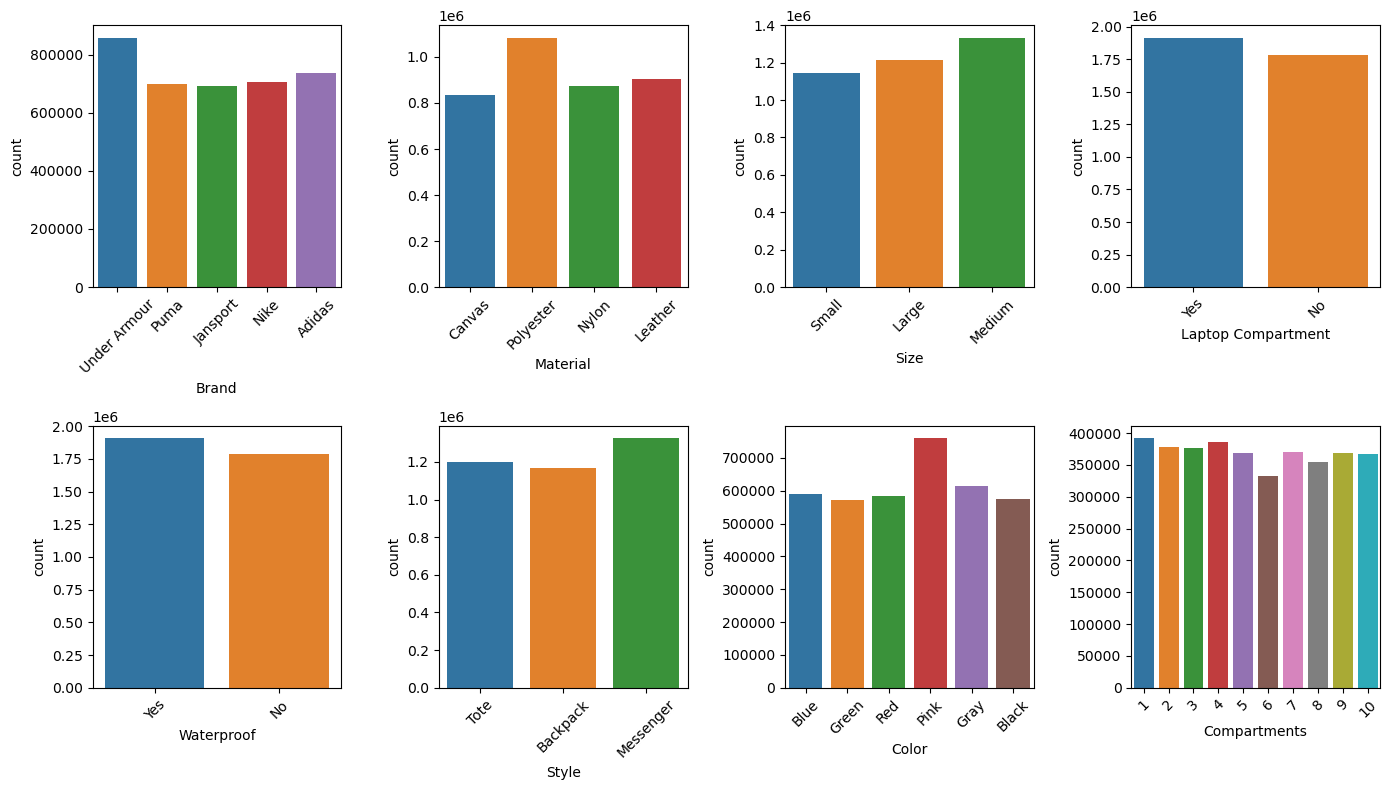

In [26]:
varqual_viz((var_qual+var_dis),data=df, nrow=2,ncol=4,size=(14,8))

#### Visualisation des variables numériques continues & test de shapiro (normalité)


In [27]:
def varnum_viz(col,data, nrow,size=(14,20)):
    """
    col : list
    data : dataframe
    nrow : int
    Pour chaque feature, cela renvoie deux figures histplot/boxplot
    """
    plt.figure(figsize=size)
    for i,k in enumerate(col):
        #histplot :
        plt.subplot(nrow,2,i*2+1)
        sns.histplot(x = k, data = data, color = "slateblue",kde=True, )
        plt.title(f"Skew : {round(df[k].skew(),2)}")
        plt.axvline(df[k].mean(), ls="--", c = "red", label = "mean")
        plt.axvline(df[k].median(),ls=":", c = "green", label = "median")
        plt.legend()
        
        #boxplot
        plt.subplot(nrow,2,i*2+2)
        sns.boxplot(x = k, data = data, color="orange", showmeans=True)
        plt.tight_layout()
    plt.show()

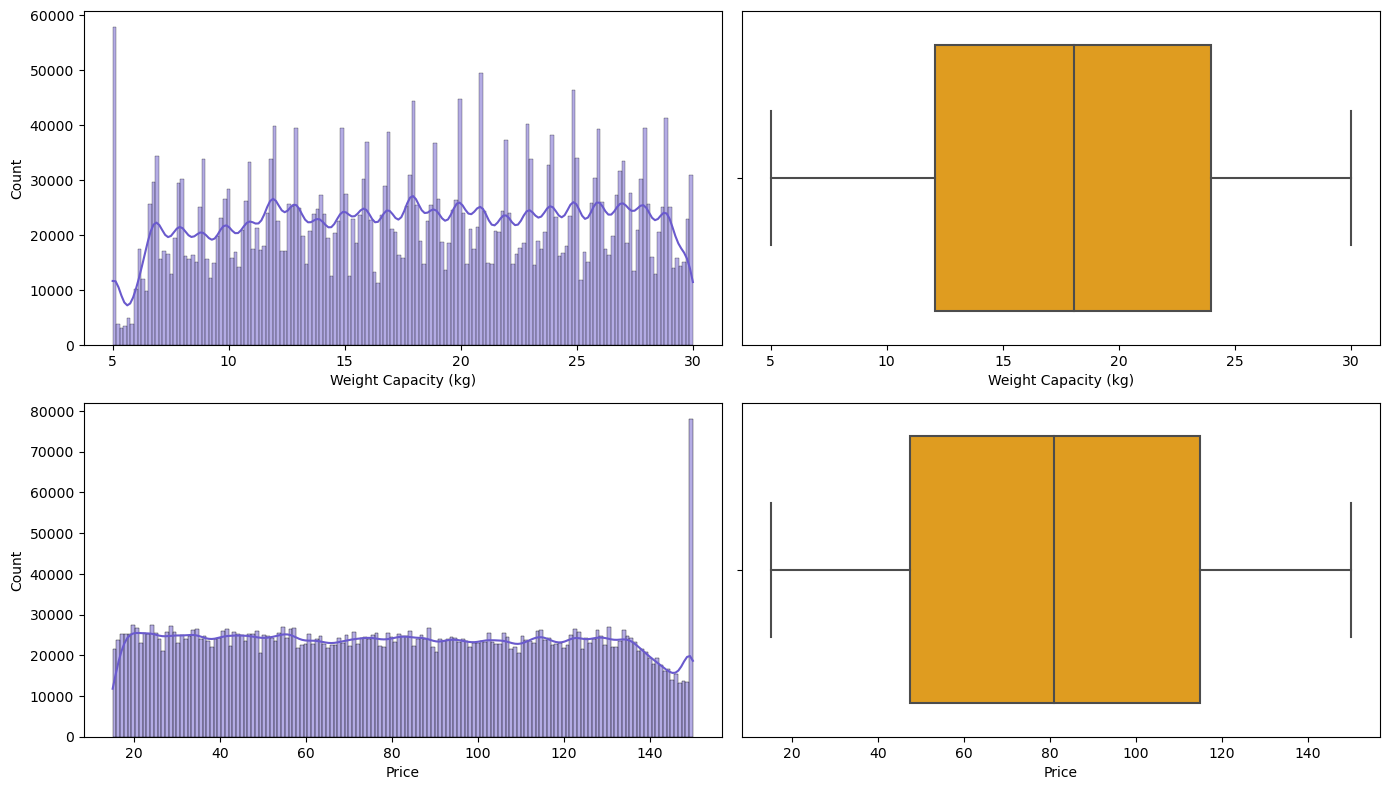

In [28]:
varnum_viz(var_num,data=df, nrow=2,ncol=2,size=(14,8))

In [29]:
def shapiro_test(list_col):
    """
    Cette fonction teste si list_col est une liste,
    si ce n'est pas le cas, elle convertit le texte en liste avant d'effectuer un test de shapiro 
    pour vérifier si la caractéristique suit une distribution normale.
        """
    if type(list_col) != list:
        list_col = [list_col]

    accepted,rejected = [], []

    for col in df[list_col]:
        stat, p_value = shapiro(df[col])  
        alpha = 0.05
        if p_value > alpha: 
            result = colored('Accepter', 'green')  
            accepted.append(col)
        else:
            result = colored('Rejet','red')        
            rejected.append(col)

        print(f'{col:-<50}\t Hypothèse: {result}')
    return accepted,rejected

In [30]:
print(colored("Test shapiro :", "blue"))
a,r = shapiro_test(var_num)

Test shapiro :
Weight Capacity (kg)------------------------------	 Hypothèse: Rejet
Price---------------------------------------------	 Hypothèse: Rejet


## Analyse bivariée : Target Vs features
### Target vs variables continues


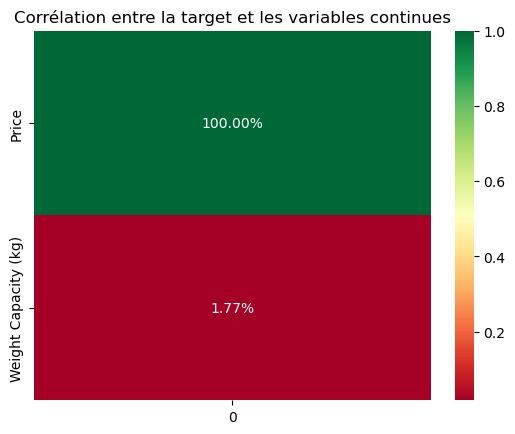

In [31]:
correlation = df[var_num].corrwith(df['Price']) #corrwith() permet de calculer la corrélation entre
#la target et chaque variable continue

# Trier les valeurs de corrélation par ordre décroissant
sorted_correlation = correlation.sort_values(ascending=False)
# plt.figure(figsize=(10, 20))
heatmap = sns.heatmap(pd.DataFrame(sorted_correlation), annot=True, cmap='RdYlGn',fmt=".2%", cbar=True)
heatmap.set_title('Corrélation entre la target et les variables continues')
plt.show()

### Target vs variables qualitatives/discrètes


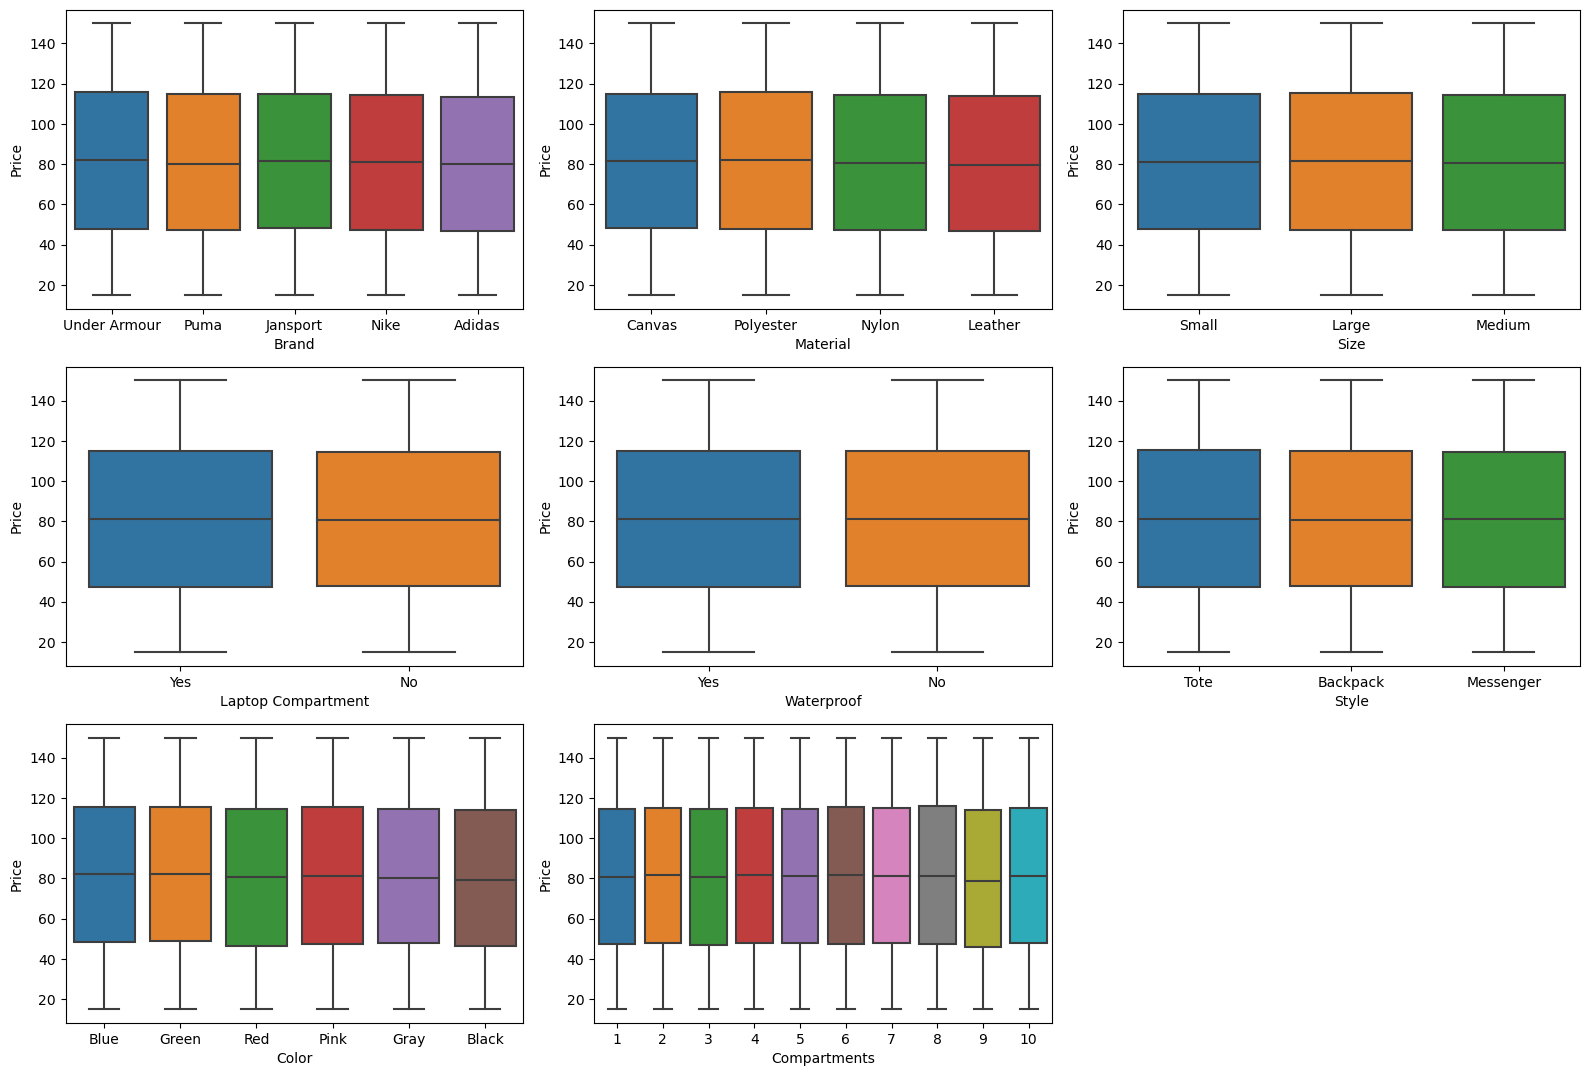

In [32]:
plt.figure(figsize=(16,14))
for i,col in enumerate(var_qual+var_dis,1):
    plt.subplot(4,3,i)
    sns.boxplot(x=col, y = "Price", data = df)
plt.tight_layout()

#### Très peu de variation entre la target et l'ensemble des features, 


###  visualisation multivariée: 
####  Analyse du prix *moyen* en fonction de différentes features :
- Marque, matériel en fonction du prix : 

In [34]:
df_temp = df.groupby(["Brand","Material"])["Price"].mean().reset_index()
print("dim :", df_temp.shape)
df_temp.head()

dim : (20, 3)


,Brand,Material,Price
0,Adidas,Canvas,81.131571
1,Adidas,Leather,79.646212
2,Adidas,Nylon,80.205089
3,Adidas,Polyester,81.018986
4,Jansport,Canvas,82.087223


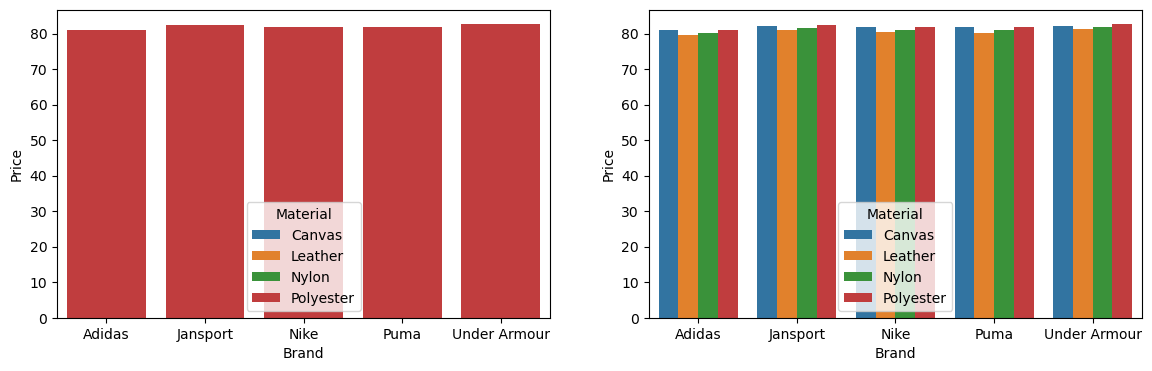

In [35]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.barplot(x = "Brand", y = "Price", hue = "Material", data=df_temp, dodge=False, )
plt.subplot(1,2,2)
sns.barplot(x = "Brand", y = "Price", hue = "Material", data=df_temp, dodge=True, )
plt.show()

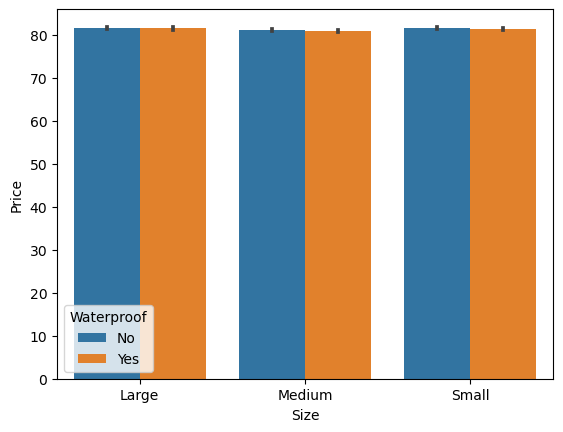

In [36]:
df_temp = df.groupby(["Size","Compartments","Waterproof"])["Price"].mean().reset_index()
sns.barplot(x = "Size", y = "Price", hue = "Waterproof", data=df_temp, dodge=True, )
plt.show()

Comme dans la partie bivariée, les données sont très proches  les unes des autres, il n'y a quasi aucune variabilité

#### On peut regarder en fonction du prix, sans aggreger au prix moyen avec d'autres visualisation :

In [37]:
df_temp = df.sample(10000, random_state=42) #récupération d'une partie des données

In [38]:
def violin_stripplot(col_x, col_hue):
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    ax = sns.violinplot( x = col_x, y = "Price", hue = col_hue, data = df_temp)
    ax.set_xlabel(col_x, color="blue",fontweight="bold")
    ax.set_ylabel("Price", color="red",fontweight="bold")

    legend = plt.legend(bbox_to_anchor=(0, 1))  
    legend.set_title(col_hue)  # pour remettre le titre de la légende
    
    plt.subplot(1,2,2)
    ax = sns.stripplot( x = col_x, y = "Price", hue = col_hue, data = df_temp)
    ax.set_xlabel(col_x, color="blue",fontweight="bold")
    ax.set_ylabel("Price", color="red",fontweight="bold")

    legend = plt.legend(bbox_to_anchor=(1, 1))  
    legend.set_title(col_hue)
    plt.show()

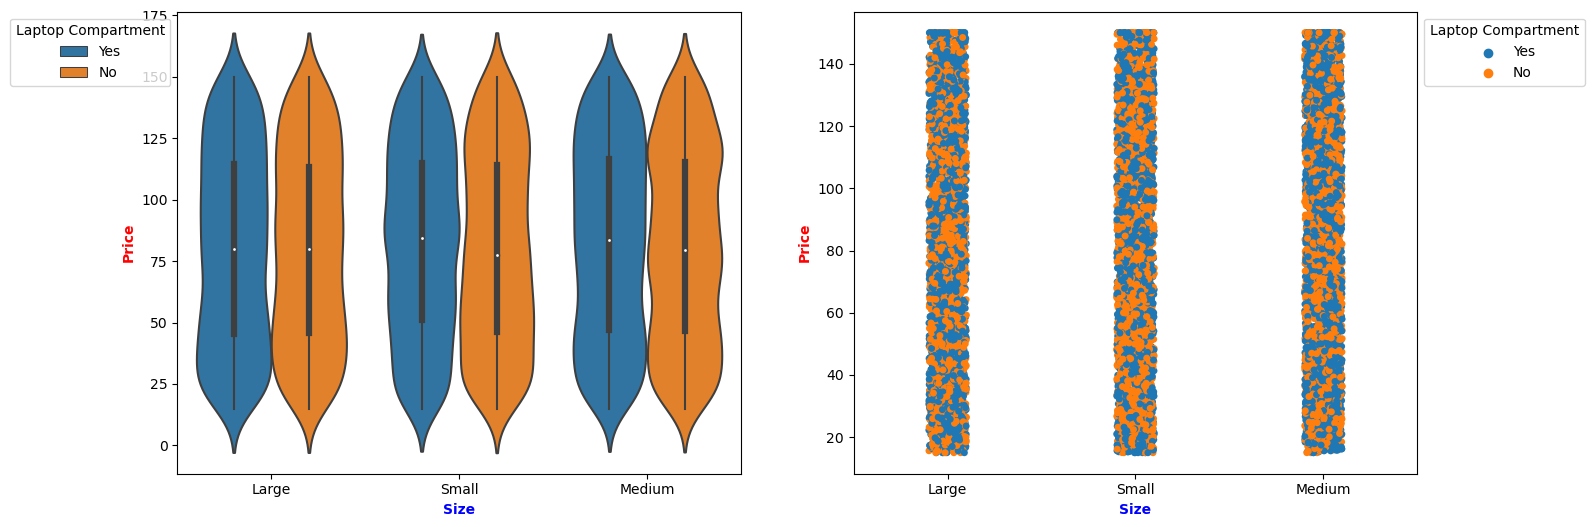

In [39]:
violin_stripplot("Size","Laptop Compartment" )

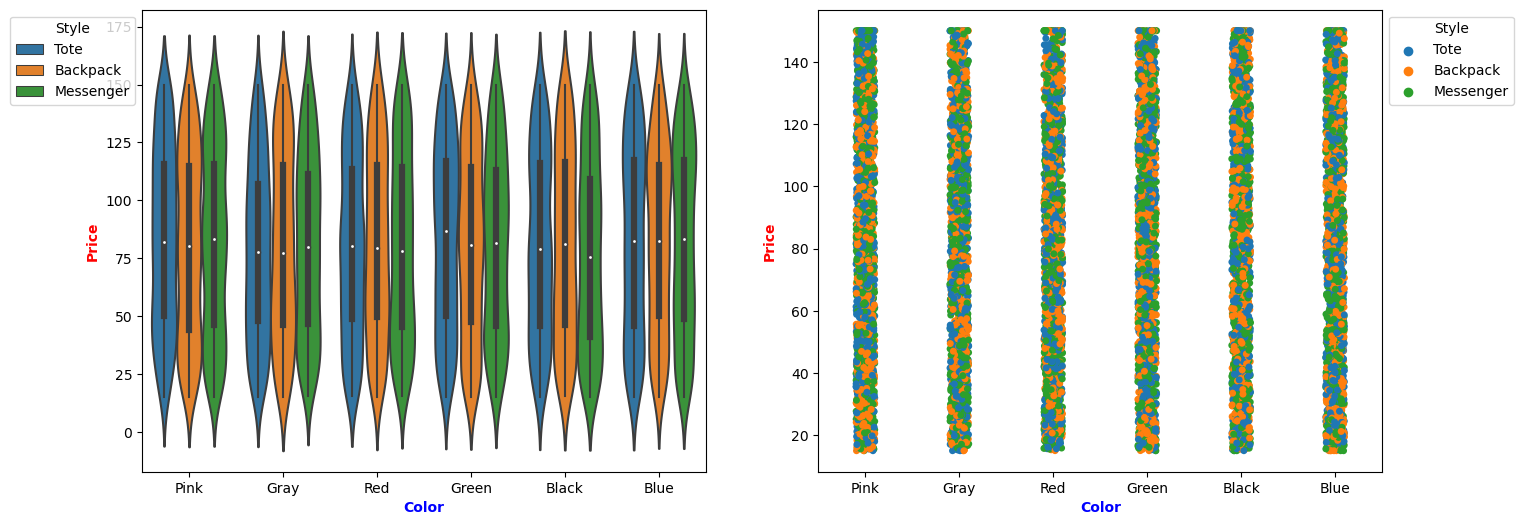

In [40]:
violin_stripplot("Color","Style" )

# Bilan visualisation : 
- Bivariée comme multivariée, on ne voit quasi **aucune variation**, Les prix des sacs n'ont l'air de dépendre ni des caractéristiques esthétiques (color, style, materials, brand) ni des caractéristiques pratiques (taille, laptop compartment, size,..)

## 4. Test statistique


### Target Vs features continue :

Nous faisons le test de Kendall car au test de normalité, les features ne suivaient pas une loi normale

In [ ]:
def kendall(features, target,dataframe,retour=False):
    """
    Fonction qui effectue un test de Kendall entre une variable qualitative et une variable continue
    features : liste de feature ou feature unique
    target : nom de la target
    dataframe : jeu de donnée contenant les features et la target
    renvoi un tuple de liste, le premier élément du tuple sont les variables à conserver, le second les variables à
    supprimer
    """
    var_a_conserver, var_a_supprimer = [],[]
    #si l'utilisateur n'entre qu'une seule feature, on la met en liste :
    if type(features) == str:
        features = [features]
    print(colored("P-values :","blue")) 
    print()

    
    #test correlation : 
    for feat in features:
        stat, pval = kendalltau(dataframe[feat],dataframe[target]) #test kendall
        alpha = 0.05
        if pval<alpha:
            print(f'{colored(feat,"green")} : {pval}')
            var_a_conserver.append(feat)
        else:
            print(f'{colored(feat,"red")} : {pval}')

            var_a_supprimer.append(feat)
    print()        
    print(colored("Variable a conserver ","green", attrs=["bold"]), var_a_conserver)
    print(colored("Variable a supprimer ","red", attrs=["bold"]), var_a_supprimer)
    if retour :
        return var_a_conserver, var_a_supprimer
        

In [ ]:
kendall(var_num, "Price",df)

### Target vs variables discretes + qualitatives
- Si la feature possède 2 modalité, un test de man whitney sera effectué, sinon dans le cas contraire (>2) un test de kruskal wallis 

In [ ]:
col_manwhitney, col_kruskal =  [], []

for i in var_qual+var_dis:
    if df[i].nunique() == 2:
        col_manwhitney.append(i)
    else:
        col_kruskal.append(i)

In [ ]:
def manwithney(features, target, dataframe, retour=False):
        """
    Fonction qui effectue un test de Man Withney entre une variable qualitative et une variable continue
    features : liste de feature ou feature unique
    target : nom de la target
    dataframe : jeu de donnée contenant les features et la target
    renvoi un tuple de liste, le premier élément du tuple sont les variables à conserver, le second les variables à
    supprimer
    """

    var_a_conserver, var_a_supprimer = [], []
    #si l'utilisateur n'entre qu'une seule feature, on la met en liste :
    if isinstance(features, str):
        features = [features]

    print(colored("P-values :", "blue")) 
    print()

    # Test de Mann-Whitney sur chaque variable continue
    for feat in features:
        # Séparation en deux groupes selon `target`
        group1 = dataframe[dataframe[target] == dataframe[target].unique()[0]][feat]
        group2 = dataframe[dataframe[target] == dataframe[target].unique()[1]][feat]

        # Mann-Whitney test
        stat, pval = mannwhitneyu(group1, group2)
        alpha = 0.05  # Seuil de significativité

        if pval < alpha:
            print(f'{colored(feat, "green")} : {pval}')
            var_a_conserver.append(feat)
        else:
            print(f'{colored(feat, "red")} : {pval}')
            var_a_supprimer.append(feat)

    print()There is some debate
    print(colored("Feature to keep", "green", attrs=["bold"]), var_a_conserver)
    print(colored("Feature to delete", "red", attrs=["bold"]), var_a_supprimer)

    if retour:
        return var_a_conserver, var_a_supprimer

    
    
def kruskal_wallis(feature, target, dataframe,retour=False):
    var_a_conserver = []
    var_a_supprimer = []

    # Test si la feature est une liste ou simplement une feature
    if type(feature) == str:
        feature = [feature]
    print(colored("P-values :","blue")) 

    for feat in feature:
        # Séparer les données en fonction des différentes valeurs prises par la variable qualitatives
        grouped_data = [dataframe.loc[dataframe[target] == category, feat] for category in dataframe[target].unique()]

        # Effectuer le test de Kruskal-Wallis
        statistic, pval = kruskal(*grouped_data)

        # Interpréter les résultats
        alpha = 0.05  # Niveau de signification
        if pval<alpha:
            print(f'{colored(feat,"green")} : {pval}')
            var_a_conserver.append(feat)
        else:
            print(f'{colored(feat,"red")} : {pval}')

            var_a_supprimer.append(feat)
    print()        
    print(colored("Variable a conserver ","green", attrs=["bold"]), var_a_conserver)
    print(colored("Variable a supprimer ","red", attrs=["bold"]), var_a_supprimer)
    if retour :
        return var_a_conserver, var_a_supprimer

In [ ]:
manwithney(col_manwhitney, "Price",df)

#### Attention le code ci-dessous est long à s'exécuter

In [ ]:
%time
kruskal_wallis(col_kruskal,  "Price",df)

## Bilan des tests statistiques :

- Le test de Man whitney nous indique qu'une features discrète n'est pas à conserver
- Le test de kruskal lui, nous indique de conserver l'ensemble des features, même si, visuellement, il n'y a que très peu de variation. C'est sûrement la taille de l'échantillon, qui est très élevée, qui est à l'origine du résultat.
**Même avec une faible variation des valeurs, les p-values obtenues sont presque garanties d'être significatives**

* Nous pouvons décider de garder l'ensemble des features pour la modélisation, et observer les résultats obtenues :
    - Si overfitting par exemple, nous pourrons revenir ici et supprimer la/les features que nos tests statistiques ont jugés aucune dépendance

## 5. Preprocessing : Standardisation et encodage
### train/test : 
- Imputation du test
- Standardisation
- Encodage
- Enregistrement du dataframe


#### imputation du test :

In [41]:
test.isnull().sum()[test.isnull().sum()>0] #données manquantes pour les memes colonnes que le train

Brand                   6227
Material                5613
Size                    4381
Laptop Compartment      4962
Waterproof              4811
Style                   5153
Color                   6785
Weight Capacity (kg)      77
dtype: int64

In [42]:
#  Utilisation des imputers qui ont été entrainés 
test[var_num_NaN] = imputer_mean.transform(test[var_num_NaN])
test[var_qual_NaN] = imputer_mode.transform(test[var_qual_NaN])

#### Standardisation des données 

In [43]:
# il faut retirer la target de la standardisation :
target = df["Price"]
var_num.remove(target.name)

In [44]:
scaler = StandardScaler()
scaler.fit(df[var_num]) #entrainement
df[var_num] = scaler.transform(df[var_num]) #transformation
test[var_num] = scaler.transform(test[var_num]) #transformation

#### note du 25/03/25 : 
- au dessus j'aurai du fit sur split le df et faire :
    - scaler.fit(X_train[var_num])
    - scaler.transform(X[var_num])
    - scaler.transform(test[var_num])

#### Encodages des données :

A part la features Compartments qui est déjà une variable discrète et qui n'a pas besoin d'encodage,  toutes les autres features qualitatives sont **nominales** et non **ordinales**. Donc nous allons effectuer un encodage **One Hot**

In [45]:
# Initialisation de l'encodeur OneHotEncoder
# - sparse=False : Retourne une matrice dense, pratique pour la manipulation directe.
# - drop='first' : Supprime la première catégorie pour chaque variable afin d'éviter la colinéarité.

encoder = OneHotEncoder(sparse=False, drop='first',handle_unknown='ignore')
# handle_unknown='ignore' permet de gérer les catégories inconnues dans les données de test


# Entraînement et transformation des variables qualitatives
encoded_columns = encoder.fit_transform(df[var_qual])

# Conversion des données encodées en DataFrame avec des noms explicites pour les colonnes
# - get_feature_names_out() : Génère des noms clairs comme 'Gender_Male' ou 'Color_Blue'.

var_qual_encoded = encoder.get_feature_names_out()

encoded_df = pd.DataFrame(encoded_columns,
                          columns=var_qual_encoded
                          )
encoded_df.head()

,Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,Material_Leather,Material_Nylon,Material_Polyester,Size_Medium,Size_Small,Laptop Compartment_Yes,Waterproof_Yes,Style_Messenger,Style_Tote,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [46]:
encoded_df.shape

(3694318, 18)

In [47]:
#Remplacement des anciennes variables qualitatives par celles encodées :
df = df.drop(var_qual, axis=1) #suppression des anciennes variables 

In [48]:
df.head(3)

,id,Compartments,Weight Capacity (kg),Price
0,500000,10,0.842285,114.11068
1,500001,4,-0.880505,129.74972
2,500002,8,-1.422139,21.37370


In [55]:
#Fusion des deux dataframes :
df = pd.concat([df, encoded_df], axis=1)
df.head(2)

,id,Compartments,Weight Capacity (kg),Price,Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,Material_Leather,Material_Nylon,...,Size_Small,Laptop Compartment_Yes,Waterproof_Yes,Style_Messenger,Style_Tote,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red
0,500000,10,0.842285,114.11068,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,500001,4,-0.880505,129.74972,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [51]:
#Suppression variable qualitatives et remplacement par le variables encodées :
test = test.drop(var_qual, axis = 1) 
test = pd.concat([test, df_test_encoded], axis = 1)
test.head()

,id,Compartments,Weight Capacity (kg),Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,Material_Leather,Material_Nylon,Material_Polyester,...,Size_Small,Laptop Compartment_Yes,Waterproof_Yes,Style_Messenger,Style_Tote,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red
0,300000,2.0,0.381806,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,300001,7.0,-0.637422,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,300002,9.0,-0.889009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,300003,1.0,0.067146,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,300004,2.0,-1.161755,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Nous avons bien une colonne de différence entre le train et le test qui correspond à la target **Price**

#### Enregistrement des DF : 

In [224]:
test.to_csv("test_preprocessed.csv")

In [58]:
df.to_csv("df_preprocessed.csv")